# Lane Detection

Experiment with lane detection (own lane, lane to left if any)

https://www.youtube.com/playlist?list=PLS1QulWo1RIa7D1O6skqDQ-JZ1GGHKK-K

https://www.youtube.com/watch?v=yvfI4p6Wyvk


## Load image and apply mask

(1080, 1920, 3)


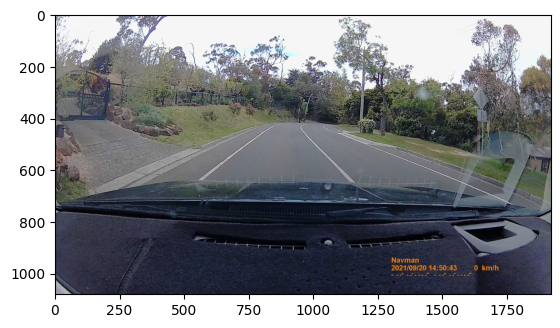

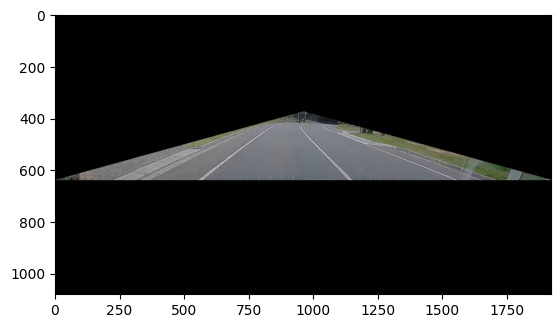

In [1]:
import os
import matplotlib.pylab as plt
import cv2
import numpy as np

sample_file = os.path.join(os.pardir, 'data_sources', 'sample_dashcam_lanes.png')

original_image = cv2.imread(sample_file)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

print(original_image.shape)
height = original_image.shape[0]
width = original_image.shape[1]

region_of_interest_vertices = [
    (0, 640),
    (width/2, 375),
    (width, 640)
]

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    channel_count = img.shape[2]
    match_mask_color = (255,) * channel_count
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
      
cropped_image = region_of_interest(original_image, np.array([region_of_interest_vertices],np.int32))

plt.imshow(original_image)
plt.show()

plt.imshow(cropped_image)
plt.show()

## Apply Canny Edge Detection

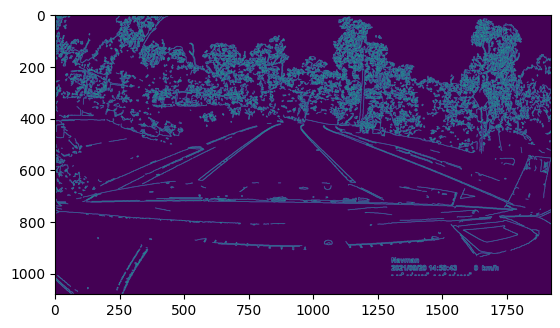

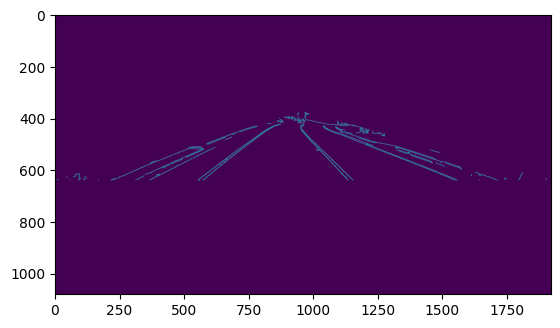

In [2]:
# Convert image to greyscale
# We want to use Canny edge detection FIRST, before cropping
# If we crop first, then the margins of the crop will be artificially detected as edges!
grey_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

blur_image = cv2.GaussianBlur(grey_image, (5, 5), 0)

canny_image = cv2.Canny(blur_image, 100, 200)

cropped_image = region_of_interest(canny_image, np.array([region_of_interest_vertices],np.int32))

plt.imshow(canny_image)
plt.show()

plt.imshow(cropped_image)
plt.show()

## Apply Hough Line Transform

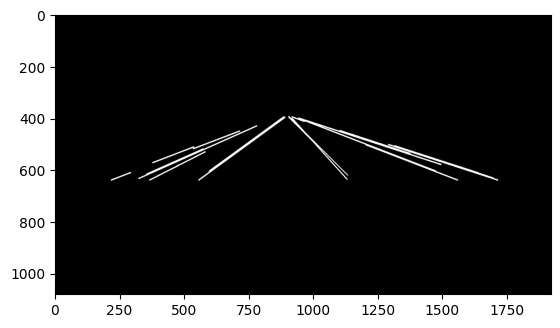

In [3]:
lines = cv2.HoughLinesP(
    cropped_image, 
    rho           = 2, 
    theta         = np.pi/60, 
    threshold     = 160, 
    lines         = np.array([]), 
    minLineLength = 10, 
    maxLineGap    = 100
)

def draw_lines(img, lines):
    img = np.copy(img)
    
    line_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 255, 255), thickness=3)
    
    #img = cv2.addWeighted(img, 0.8, line_image, 1, 0.0)
    #return img
    return line_image

image_with_lines = draw_lines(original_image, lines)
    
plt.imshow(image_with_lines)
plt.show()    

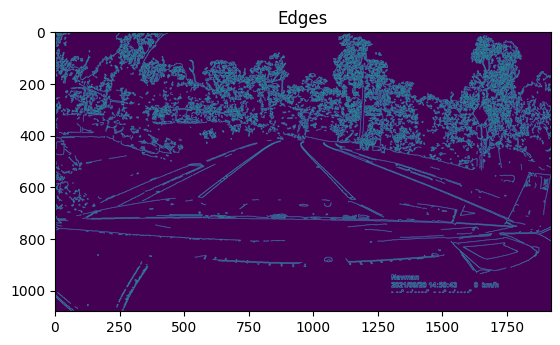

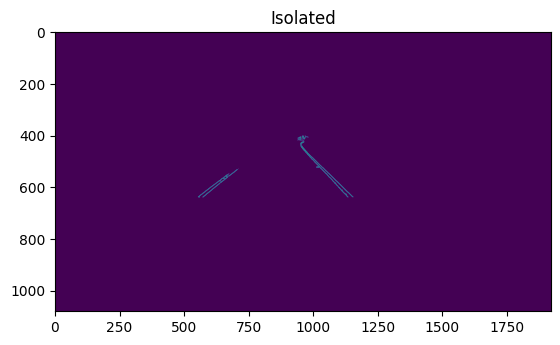

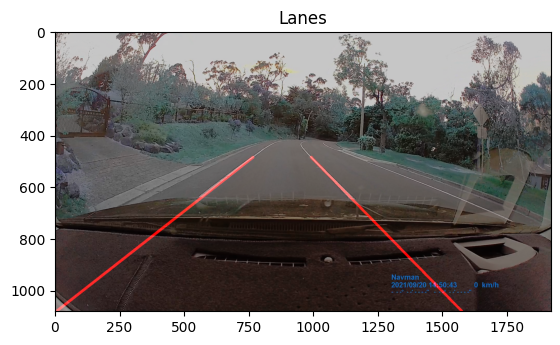

In [4]:
# https://medium.com/analytics-vidhya/building-a-lane-detection-system-f7a727c6694

import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = sample_file
image1 = cv2.imread(image_path)
plt.imshow(image1)

def grey(image):
  #convert to grayscale
    image = np.asarray(image)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  #Apply Gaussian Blur --> Reduce noise and smoothen image
def gauss(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

  #outline the strongest gradients in the image --> this is where lines in the image are
def canny(image):
    edges = cv2.Canny(image,50,150)
    return edges

def region(image, triangle):
    height, width = image.shape
    #isolate the gradients that correspond to the lane lines
    # from "triangle" parameter
    
    #create a black image with the same dimensions as original image
    mask = np.zeros_like(image)
    #create a mask (triangle that isolates the region of interest in our image)
    mask = cv2.fillPoly(mask, triangle, 255)
    mask = cv2.bitwise_and(image, mask)
    return mask

def display_lines(image, lines):
    lines_image = np.zeros_like(image)
    #make sure array isn't empty
    if lines is not None:
        for idx, line in enumerate(lines):
            x1, y1, x2, y2 = line
            #draw lines on a black image
            if idx <= 1:
                color = (255, 0, 0)
            else:
                color = (0, 255, 0)
            cv2.line(lines_image, (x1, y1), (x2, y2), color, 10)
    return lines_image

def average(image, lines, limit, left_only=False):
    left = []
    right = []

    if lines is not None:
      for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        #fit line to points, return slope and y-int
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_int = parameters[1]
        #lines on the right have positive slope, and lines on the left have neg slope
        if slope < 0:
            left.append((slope, y_int))
        else:
            right.append((slope, y_int))
            
    #takes average among all the columns (column0: slope, column1: y_int)
    if not left_only:
        right_avg = np.average(right, axis=0)
    left_avg = np.average(left, axis=0)
    #create lines based on averages calculates
    left_line, left_slope, left_int = make_points(image, left_avg, limit)
    if not left_only:
        right_line, right_slope, right_int = make_points(image, right_avg, limit)
        
    if not left_only:
        return np.array([left_line, right_line]), left_slope, left_int, right_slope, right_int
    else:
        return np.array([left_line]), left_slope, left_int

def make_points(image, average, limit):
    slope, y_int = average
    y1 = image.shape[0]
    #how long we want our lines to be --> 3/5 the size of the image
    y2 = int(y1 * limit)
    #determine algebraically
    x1 = int((y1 - y_int) // slope)
    x2 = int((y2 - y_int) // slope)
    return np.array([x1, y1, x2, y2]), slope, y_int



'''##### DETECTING lane lines in image ######'''


copy = np.copy(image1)

initial_region = np.array([
    [(500, 640), (int(width/2), 400), (width-500, 640)]
])

isolated = region(canny_image, initial_region)

plt.imshow(canny_image)
plt.title('Edges')
plt.show()

plt.imshow(isolated)
plt.title('Isolated')
plt.show()

#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
#lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=100, maxLineGap=5)

averaged_lines1, left_slope, left_int, right_slope, right_int = average(copy, lines, 9/20)
black_lines = display_lines(copy, averaged_lines1)
#taking wighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)

plt.imshow(lanes)
plt.title('Lanes')
plt.show()


# What if we do a first pass with a narrow focus to get our OWN lane, then a second pass with a shifted focus
# to get anything to the left???

print(averaged_lines1)

print(left_slope)
print(left_int)
print(right_slope)
print(right_int)

overlap_x = (right_int - left_int) / (left_slope - right_slope)

overlap_y = (overlap_x * left_slope) + left_int

print(overlap_x)
print(overlap_y)

print(int(round((640-left_int) / left_slope)))

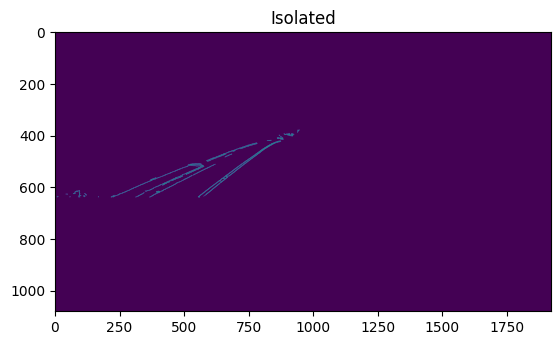

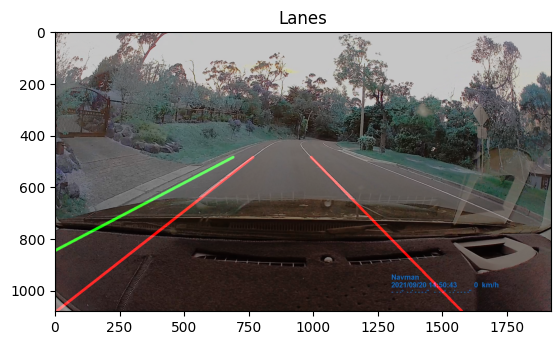

In [5]:
left_region = np.array([
    [(0, 640), (int(width/2), 375), (int(round((640 - left_int) / left_slope)), 640)]
])


isolated = region(canny_image, left_region)

plt.imshow(isolated)
plt.title('Isolated')
plt.show()

#DRAWING LINES: (order of params) --> region of interest, bin size (P, theta), min intersections needed, placeholder array, 
lines = cv2.HoughLinesP(isolated, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines2, left_slope, left_int = average(copy, lines, 9/20, left_only=True)
averaged_lines = np.array([averaged_lines1[0], averaged_lines1[1], averaged_lines2[0]])
black_lines = display_lines(copy, averaged_lines)
#taking wighted sum of original image and lane lines image
lanes = cv2.addWeighted(copy, 0.8, black_lines, 1, 1)

plt.imshow(lanes)
plt.title('Lanes')
plt.show()



In [7]:
cv2.imwrite(os.path.join(os.pardir, 'lane_demo.png'), lanes)

True